In [1]:
import pandas as pd
import numpy as np
import rdkit.Chem as Chem
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import MACCSkeys
import SimpSOM as sps

# Binding affinity analysis

### Drug-protein-metabolite dataset

The *drug_target_met.csv* file is obtained from previous work in our lab as described in the project memory, and it contains information regarding the drug-target-metabolite associations. The *inchikey_drug.csv* contains the relationship between each drug and its InChIKey, obtained by querying all the drug names in the *drug_target_met.csv* file in DrugCentral.

In [2]:
drug_tm = pd.read_csv('drug_target_met.csv', sep=',')
drug_inchi = pd.read_csv('inchikey_drug.csv', sep='\t', header=None, names=['InChIKey','Drug'])
drug_tm = pd.merge(drug_tm, drug_inchi, on=['Drug'])

In [146]:
#drug_tm.to_csv('drug_tm_inchikey.csv', sep='\t')
drug_tm.head()

,UniProtKB,Protein,Accession,Class,Units,Drug,Action,Affinity.drug,Source.drug,Metabolite,Affinity.metabolite,Source.metabolite,InChIKey
0,5HT1A_HUMAN,5-hydroxytryptamine receptor 1A,P08908,GPCR,Ki,aripiprazole,PARTIAL AGONIST,8.15,drugcentral,5-hydroxytryptamine,9.7,gtopdb,CEUORZQYGODEFX-UHFFFAOYSA-N
1,5HT2A_HUMAN,5-hydroxytryptamine receptor 2A,P28223,GPCR,Ki,aripiprazole,ANTAGONIST,7.90,drugcentral,5-hydroxytryptamine,8.4,gtopdb,CEUORZQYGODEFX-UHFFFAOYSA-N
2,DRD2_HUMAN,D(2) dopamine receptor,P14416,GPCR,Ki,aripiprazole,PARTIAL AGONIST,8.71,drugcentral,dopamine,7.2,gtopdb,CEUORZQYGODEFX-UHFFFAOYSA-N
3,5HT1A_HUMAN,5-hydroxytryptamine receptor 1A,P08908,GPCR,Ki,aripiprazole lauroxil,PARTIAL AGONIST,8.77,drugcentral,5-hydroxytryptamine,9.7,gtopdb,DDINXHAORAAYAD-UHFFFAOYSA-N
4,5HT2A_HUMAN,5-hydroxytryptamine receptor 2A,P28223,GPCR,Ki,aripiprazole lauroxil,ANTAGONIST,8.47,drugcentral,5-hydroxytryptamine,8.4,gtopdb,DDINXHAORAAYAD-UHFFFAOYSA-N


### Herbal compound-target-metabolite dataset

In [4]:
HC = PandasTools.LoadSDF('Herbal_Compounds.sdf')[['ID', 'COMPOUND_NAMES']]

In [5]:
HC = HC.rename(columns = {'ID':'InChIKey.HC', 'COMPOUND_NAMES':'HC'})
#HC.to_csv('HC_inchikey.csv', sep='\t', index=False)
inchikey = (HC['InChIKey.HC'].drop_duplicates().tolist())
#with open('HC_inchikey_list.txt', 'w') as f:
#    for elem in inchikey:
#        f.write(elem + '\n')

In [6]:
print('The number of unique herbal compounds in the HC database is: %d.' % len(inchikey))

The number of unique herbal compounds in the HC database is: 6432.


*HC_inchikey_list.txt* &rarr; ChEMBL &rarr; obtain target proteins and the corresponding binding affinities

In [7]:
HC_aff = pd.read_csv('HC_affinities.csv', sep='\t', 
                     names=['InChIKey', 'HC', 'Accession', 'Species', 'Protein', 'sum_activity', 'pchembl_values'])

In [8]:
a = HC_aff['pchembl_values'].tolist()
a = [item.split(']')[1] for item in a]
d_a = { i : a[i] for i in range(0, len(a) ) }
Ki,Kd,EC50,IC50 = [],[],[],[]

for i in range(len(a)):


    if '|' in d_a[i]:
        d_a[i] = d_a[i].replace('|',', ')

    if 'Ki' in d_a[i]:
        where = d_a[i].find('Ki: ') + 4
        Ki.append(d_a[i][where:where+4])
    else:
        Ki.append('NA')

    if 'Kd' in d_a[i]:
        where = d_a[i].find('Kd: ') + 4
        Kd.append(d_a[i][where:where+4])
    else:
        Kd.append('NA')

    if 'IC50' in d_a[i]:
        where = d_a[i].find('IC50: ') + 6
        IC50.append(d_a[i][where:where+4])
    else:
        IC50.append('NA')

    if 'EC50' in d_a[i]:
        where = d_a[i].find('EC50: ') + 6
        EC50.append(d_a[i][where:where+4])
    else:
        EC50.append('NA')

HC_aff['pKi'] = Ki
HC_aff['pKd'] = Kd
HC_aff['pIC50'] = IC50
HC_aff['pEC50'] = EC50

HC_aff.head()

,InChIKey,HC,Accession,Species,Protein,sum_activity,pchembl_values,pKi,pKd,pIC50,pEC50
0,UAHGNXFYLAJDIN-IZZDOVSWSA-N,4'-HYDROXYCHALCONE,P13726,Homo sapiens,Coagulation factor III,9.92,[1]IC50: 9.92,NA,NA,9.92,NA
1,PROQIPRRNZUXQM-ZXXIGWHRSA-N,ESTRIOL,Q92731,Homo sapiens,Estrogen receptor beta,9.90,[1]EC50: 9.90,NA,NA,NA,9.90
2,YNNUSGIPVFPVBX-NHCUHLMSSA-N,CLEMASTINE,P35367,Homo sapiens,Histamine H1 receptor,9.85,[2]IC50: 9.38|Ki: 10.3,10.3,NA,9.38,NA
3,QYSXJUFSXHHAJI-YRZJJWOYSA-N,CHOLECALCIFEROL,P11473,Homo sapiens,Vitamin D receptor,9.68,[1]EC50: 9.68,NA,NA,NA,9.68
4,DRLFMBDRBRZALE-UHFFFAOYSA-N,MELATONIN,P48039,Homo sapiens,Melatonin receptor 1A,9.50,[85]Ki: 9.60|EC50: 9.43|IC50: 9.18|Kd: 9.82,9.60,9.82,9.18,9.43


In [9]:
met = pd.read_csv('metabolite_proteins_list.tsv', sep='\t')
met = met.rename(columns={'uniprot':'Accession'})
HC_aff_met = pd.merge(HC_aff, met, on=['Accession'], how='inner')
#HC_aff_met.to_csv('HC_affinities2.csv', sep='\t', index=False)

In [10]:
HC_aff2 = pd.read_csv('HC_affinities2.csv', sep='\t')
HC_aff2 = HC_aff2[['swissprot', 'Protein', 'Accession', 'target_class', 'affinity_units', 'HC', 
                   'InChIKey', 'Affinity.HC', 'ligand_name', 'MAX_MET_AFFINITY']]
HC_aff2.columns = ['UniProtKB', 'Protein', 'Accession', 'Class', 'Units', 'HC', 'InChIKey.HC',
                   'Affinity.HC', 'Metabolite', 'Affinity.metabolite']
HC_aff2 = HC_aff2.drop_duplicates().dropna()
HC = pd.read_csv('HC_inchikey.csv', sep='\t')
HC_tm = pd.merge(HC, HC_aff2, on=['InChIKey.HC'], how='inner')
HC_tm = HC_tm.rename(columns={'HC_x' : 'HC.db', 'HC_y': 'HC.chembl'})
HC_tm = HC_tm[['UniProtKB',  'Protein', 'Accession', 'Class', 'Units', 'HC.db', 'HC.chembl', 'InChIKey.HC',
                   'Affinity.HC', 'Metabolite', 'Affinity.metabolite']]
#HC_tm.to_csv('HC_target_metabolite.csv', sep='\t', index=False)

In [11]:
print('The number of herbal compounds-protein-metabolite associations is: %d.' % len(HC_tm))

The number of herbal compounds-protein-metabolite associations is: 297.


In [12]:
HC_tm.head()

,UniProtKB,Protein,Accession,Class,Units,HC.db,HC.chembl,InChIKey.HC,Affinity.HC,Metabolite,Affinity.metabolite
0,ESR2_HUMAN,Estrogen receptor beta,Q92731,Nuclear hormone receptor,Ki,DAIDZEIN|DAIDZEN,DAIDZEIN,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,6.52,17β-estradiol,9.34
1,ESR1_HUMAN,Estrogen receptor alpha,P03372,Nuclear hormone receptor,Ki,DAIDZEIN|DAIDZEN,DAIDZEIN,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,5.75,17β-estradiol,9.82
2,5HT1A_HUMAN,Serotonin 1a (5-HT1a) receptor,P08908,GPCR,Ki,SYNEPHRINE|SYNEPHERINE,OXEDRINE,YRCWQPVGYLYSOX-UHFFFAOYSA-N,4.20,5-hydroxytryptamine,9.70
3,ACM4_HUMAN,Muscarinic acetylcholine receptor M4,P08173,GPCR,Ki,MUSCARINE,MUSCARINE,UQOFGTXDASPNLL-XHNCKOQMSA-N,6.01,acetylcholine,5.60
4,ACM2_HUMAN,Muscarinic acetylcholine receptor M2,P08172,GPCR,Ki,MUSCARINE,MUSCARINE,UQOFGTXDASPNLL-XHNCKOQMSA-N,7.04,acetylcholine,6.50


### Food compound-protein-metabolite dataset

From searching in FooDB, a file containing all the compounds with InChIKey and associated with food is generated. Then, the InChIKeys are extracted and searched in ChEMBL to obtain their target proteins and the corresponding binding affinities.

In [13]:
FC = pd.read_csv('compounds_f2014_01_good.csv', sep='\t')
FC.head()

,Unnamed: 0,name,inchikey,id,foods.name,orig_food_common_name,orig_content,orig_unit
0,0,Sucrose,CZMRCDWAGMRECN-UHFFFAOYSA-N,1131,Alfalfa,Alfalfa seeds,0.0,g
1,1,Ethanol,LFQSCWFLJHTTHZ-UHFFFAOYSA-N,753,Alfalfa,Alfalfa seeds,0.0,g
2,2,Ash,UIESIEAPEWREMY-UHFFFAOYSA-N,3513,Alfalfa,Alfalfa seeds,3.1,g
3,3,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,13393,Alfalfa,Alfalfa seeds,7.4,g
4,4,Retinol,FPIPGXGPPPQFEQ-MKOSUFFBSA-N,13831,Alfalfa,Alfalfa seeds,0.0,RE


In [14]:
FC_inchikey = (FC['inchikey'].drop_duplicates().tolist())
#with open('FC_inchikey_list.txt', 'w') as f:
#    for elem in FC_inchikey:
#        f.write(elem + '\n')

Then, the InChIKeys are extracted and searched in ChEMBL to obtain their target proteins and the corresponding binding affinities.

In [15]:
FC_aff = pd.read_csv('FC_affinities.csv', sep='\t',
                     names=['InChIKey', 'FC', 'Accession', 'Species', 'Protein', 'sum_activity', 'pchembl_values'])

In [16]:
FC_aff.head()

,InChIKey,FC,Accession,Species,Protein,sum_activity,pchembl_values
0,PROQIPRRNZUXQM-ZXXIGWHRSA-N,ESTRIOL,Q92731,Homo sapiens,Estrogen receptor beta,9.90,[1]EC50: 9.90
1,LDCYZAJDBXYCGN-VIFPVBQESA-N,OXITRIPTAN,P28335,Homo sapiens,Serotonin 2c (5-HT2c) receptor,9.70,[2]EC50: 9.70
2,DRLFMBDRBRZALE-UHFFFAOYSA-N,MELATONIN,P48039,Homo sapiens,Melatonin receptor 1A,9.50,[85]Ki: 9.60|EC50: 9.43|IC50: 9.18|Kd: 9.82
3,DRLFMBDRBRZALE-UHFFFAOYSA-N,MELATONIN,P49286,Homo sapiens,Melatonin receptor 1B,9.38,[76]Ki: 9.46|EC50: 9.37|IC50: 8.95|Kd: 9.82
4,CIWBSHSKHKDKBQ-JLAZNSOCSA-N,ASCORBIC ACID,P18089,Homo sapiens,Alpha-2b adrenergic receptor,9.30,[1]EC50: 9.30


In [17]:
a = FC_aff['pchembl_values'].tolist()
a = [item.split(']')[1] for item in a]
d_a = { i : a[i] for i in range(0, len(a) ) }
Ki,Kd,EC50,IC50 = [],[],[],[]

for i in range(len(a)):


    if '|' in d_a[i]:
        d_a[i] = d_a[i].replace('|',', ')

    if 'Ki' in d_a[i]:
        where = d_a[i].find('Ki: ') + 4
        Ki.append(d_a[i][where:where+4])
    else:
        Ki.append('NA')

    if 'Kd' in d_a[i]:
        where = d_a[i].find('Kd: ') + 4
        Kd.append(d_a[i][where:where+4])
    else:
        Kd.append('NA')

    if 'IC50' in d_a[i]:
        where = d_a[i].find('IC50: ') + 6
        IC50.append(d_a[i][where:where+4])
    else:
        IC50.append('NA')

    if 'EC50' in d_a[i]:
        where = d_a[i].find('EC50: ') + 6
        EC50.append(d_a[i][where:where+4])
    else:
        EC50.append('NA')

FC_aff['pKi'] = Ki
FC_aff['pKd'] = Kd
FC_aff['pIC50'] = IC50
FC_aff['pEC50'] = EC50

FC_aff.head()

,InChIKey,FC,Accession,Species,Protein,sum_activity,pchembl_values,pKi,pKd,pIC50,pEC50
0,PROQIPRRNZUXQM-ZXXIGWHRSA-N,ESTRIOL,Q92731,Homo sapiens,Estrogen receptor beta,9.90,[1]EC50: 9.90,NA,NA,NA,9.90
1,LDCYZAJDBXYCGN-VIFPVBQESA-N,OXITRIPTAN,P28335,Homo sapiens,Serotonin 2c (5-HT2c) receptor,9.70,[2]EC50: 9.70,NA,NA,NA,9.70
2,DRLFMBDRBRZALE-UHFFFAOYSA-N,MELATONIN,P48039,Homo sapiens,Melatonin receptor 1A,9.50,[85]Ki: 9.60|EC50: 9.43|IC50: 9.18|Kd: 9.82,9.60,9.82,9.18,9.43
3,DRLFMBDRBRZALE-UHFFFAOYSA-N,MELATONIN,P49286,Homo sapiens,Melatonin receptor 1B,9.38,[76]Ki: 9.46|EC50: 9.37|IC50: 8.95|Kd: 9.82,9.46,9.82,8.95,9.37
4,CIWBSHSKHKDKBQ-JLAZNSOCSA-N,ASCORBIC ACID,P18089,Homo sapiens,Alpha-2b adrenergic receptor,9.30,[1]EC50: 9.30,NA,NA,NA,9.30


In [18]:
FC_aff_met = pd.merge(FC_aff, met, on=['Accession'], how='inner')
#FC_aff_met.to_csv('metab_target_comp.csv', sep='\t', index=False)
FC_aff_met.head()

,InChIKey,FC,Accession,Species,Protein,sum_activity,pchembl_values,pKi,pKd,pIC50,pEC50,Unnamed: 0,swissprot,target_class,ligand_name,affinity_units,MAX_MET_AFFINITY,MEAN_MET_AFFINITY,MIN_MET_AFFINITY
0,PROQIPRRNZUXQM-ZXXIGWHRSA-N,ESTRIOL,Q92731,Homo sapiens,Estrogen receptor beta,9.90,[1]EC50: 9.90,NA,NA,NA,9.90,294,ESR2_HUMAN,Nuclear hormone receptor,17β-estradiol,Ki,9.34,9.34,9.34
1,VOXZDWNPVJITMN-ZBRFXRBCSA-N,ESTRADIOL,Q92731,Homo sapiens,Estrogen receptor beta,9.07,[128]IC50: 8.71|EC50: 9.25|Ki: 9.59|Kd: 9.26,9.59,9.26,8.71,9.25,294,ESR2_HUMAN,Nuclear hormone receptor,17β-estradiol,Ki,9.34,9.34,9.34
2,RGLYKWWBQGJZGM-ISLYRVAYSA-N,DIETHYLSTILBESTROL,Q92731,Homo sapiens,Estrogen receptor beta,8.91,[7]EC50: 9.38|Ki: 9.66|IC50: 7.30,9.66,NA,7.30,9.38,294,ESR2_HUMAN,Nuclear hormone receptor,17β-estradiol,Ki,9.34,9.34,9.34
3,ZZIALNLLNHEQPJ-UHFFFAOYSA-N,COUMESTROL,Q92731,Homo sapiens,Estrogen receptor beta,7.92,[5]IC50: 7.92,NA,NA,7.92,NA,294,ESR2_HUMAN,Nuclear hormone receptor,17β-estradiol,Ki,9.34,9.34,9.34
4,BFPYWIDHMRZLRN-SLHNCBLASA-N,ETHINYL ESTRADIOL,Q92731,Homo sapiens,Estrogen receptor beta,7.92,[2]IC50: 7.92,NA,NA,7.92,NA,294,ESR2_HUMAN,Nuclear hormone receptor,17β-estradiol,Ki,9.34,9.34,9.34


In [19]:
FC_aff2 = pd.read_csv('metab_target_comp2.csv', sep='\t')
FC_aff2 = FC_aff2[['swissprot', 'Protein', 'Accession', 'target_class', 'affinity_units', 'FC', 
                   'InChIKey', 'affinity.FC', 'ligand_name', 'MAX_MET_AFFINITY']]
FC_aff2.columns = ['UniProtKB', 'Protein', 'Accession', 'Class', 'Units', 'FC', 'InChIKey.FC',
                   'Affinity.FC', 'Metabolite', 'Affinity.metabolite']
FC_aff2 = FC_aff2.drop_duplicates().dropna()
FC_tm = FC_aff2.reset_index(drop=True)
#FC_tm.to_csv('FC_target_metabolite.csv', sep='\t', index=False)
FC_tm.head()

,UniProtKB,Protein,Accession,Class,Units,FC,InChIKey.FC,Affinity.FC,Metabolite,Affinity.metabolite
0,ESR2_HUMAN,Estrogen receptor beta,Q92731,Nuclear hormone receptor,Ki,ESTRADIOL,VOXZDWNPVJITMN-ZBRFXRBCSA-N,9.59,17β-estradiol,9.34
1,ESR2_HUMAN,Estrogen receptor beta,Q92731,Nuclear hormone receptor,Ki,DIETHYLSTILBESTROL,RGLYKWWBQGJZGM-ISLYRVAYSA-N,9.66,17β-estradiol,9.34
2,ESR2_HUMAN,Estrogen receptor beta,Q92731,Nuclear hormone receptor,Ki,GENISTEIN,TZBJGXHYKVUXJN-UHFFFAOYSA-N,8.42,17β-estradiol,9.34
3,ESR2_HUMAN,Estrogen receptor beta,Q92731,Nuclear hormone receptor,Ki,DAIDZEIN,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,6.52,17β-estradiol,9.34
4,ESR2_HUMAN,Estrogen receptor beta,Q92731,Nuclear hormone receptor,Ki,EMODIN,RHMXXJGYXNZAPX-UHFFFAOYSA-N,5.82,17β-estradiol,9.34


### Getting rid of the joint compounds

In [20]:
HC_tm = HC_tm.rename(columns={'InChIKey.HC':'InChIKey'})
FC_tm = FC_tm.rename(columns={'InChIKey.FC':'InChIKey'})

In [21]:
D_FC_common = set(pd.merge(drug_tm, FC_tm, on=['InChIKey'])['InChIKey'])
D_FC_common

{'CEUORZQYGODEFX-UHFFFAOYSA-N',
 'DZGWFCGJZKJUFP-UHFFFAOYSA-N',
 'OROGSEYTTFOCAN-DNJOTXNNSA-N',
 'PROQIPRRNZUXQM-ZXXIGWHRSA-N',
 'RGLYKWWBQGJZGM-ISLYRVAYSA-N',
 'RYYVLZVUVIJVGH-UHFFFAOYSA-N',
 'VYFYYTLLBUKUHU-UHFFFAOYSA-N',
 'ZFXYFBGIUFBOJW-UHFFFAOYSA-N'}

In [22]:
D_HC_common = set(pd.merge(drug_tm, HC_tm, on=['InChIKey'])['InChIKey'])
D_HC_common

{'CYQFCXCEBYINGO-IAGOWNOFSA-N',
 'DZGWFCGJZKJUFP-UHFFFAOYSA-N',
 'NTYJJOPFIAHURM-UHFFFAOYSA-N',
 'OROGSEYTTFOCAN-DNJOTXNNSA-N',
 'PROQIPRRNZUXQM-ZXXIGWHRSA-N',
 'RYYVLZVUVIJVGH-UHFFFAOYSA-N',
 'SFLSHLFXELFNJZ-QMMMGPOBSA-N',
 'SONNWYBIRXJNDC-VIFPVBQESA-N',
 'UQCNKQCJZOAFTQ-ISWURRPUSA-N',
 'VMWNQDUVQKEIOC-CYBMUJFWSA-N',
 'VYFYYTLLBUKUHU-UHFFFAOYSA-N',
 'XEYBRNLFEZDVAW-ARSRFYASSA-N',
 'YNNUSGIPVFPVBX-NHCUHLMSSA-N',
 'ZFXYFBGIUFBOJW-UHFFFAOYSA-N'}

In [23]:
FC_HC_common = set(pd.merge(FC_tm, HC_tm, on=['InChIKey'])['InChIKey'])
FC_HC_common

{'APJYDQYYACXCRM-UHFFFAOYSA-N',
 'BHHGXPLMPWCGHP-UHFFFAOYSA-N',
 'BTXNYTINYBABQR-UHFFFAOYSA-N',
 'BXNJHAXVSOCGBA-UHFFFAOYSA-N',
 'DNXHEGUUPJUMQT-CBZIJGRNSA-N',
 'DRLFMBDRBRZALE-UHFFFAOYSA-N',
 'DZGWFCGJZKJUFP-UHFFFAOYSA-N',
 'FADFGCOCHHNRHF-VAWYXSNFSA-N',
 'FMHHVULEAZTJMA-UHFFFAOYSA-N',
 'GPQLHGCIAUEJQK-UHFFFAOYSA-N',
 'HSCJRCZFDFQWRP-JZMIEXBBSA-N',
 'IKGXIBQEEMLURG-NVPNHPEKSA-N',
 'LGZSMXJRMTYABD-MDZDMXLPSA-N',
 'LUKBXSAWLPMMSZ-OWOJBTEDSA-N',
 'OIPILFWXSMYKGL-UHFFFAOYSA-N',
 'OIRDTQYFTABQOQ-KQYNXXCUSA-N',
 'OQWKEEOHDMUXEO-BQYQJAHWSA-N',
 'OROGSEYTTFOCAN-DNJOTXNNSA-N',
 'PROQIPRRNZUXQM-ZXXIGWHRSA-N',
 'PVNIIMVLHYAWGP-UHFFFAOYSA-N',
 'QEWSAPKRFOFQIU-UHFFFAOYSA-N',
 'QZAYGJVTTNCVMB-UHFFFAOYSA-N',
 'RHMXXJGYXNZAPX-UHFFFAOYSA-N',
 'RJKFOVLPORLFTN-LEKSSAKUSA-N',
 'RYYVLZVUVIJVGH-UHFFFAOYSA-N',
 'SASNBVQSOZSTPD-UHFFFAOYSA-N',
 'TZBJGXHYKVUXJN-UHFFFAOYSA-N',
 'VCCRNZQBSJXYJD-UHFFFAOYSA-N',
 'VOXZDWNPVJITMN-ZBRFXRBCSA-N',
 'VYFYYTLLBUKUHU-UHFFFAOYSA-N',
 'YUSWMAULDXZHPY-UHFFFAOYSA-N',
 'ZFXYFB

In [24]:
D_HC_FC_common = (D_HC_common.union(D_FC_common)).union(FC_HC_common)
D_HC_FC_common

{'APJYDQYYACXCRM-UHFFFAOYSA-N',
 'BHHGXPLMPWCGHP-UHFFFAOYSA-N',
 'BTXNYTINYBABQR-UHFFFAOYSA-N',
 'BXNJHAXVSOCGBA-UHFFFAOYSA-N',
 'CEUORZQYGODEFX-UHFFFAOYSA-N',
 'CYQFCXCEBYINGO-IAGOWNOFSA-N',
 'DNXHEGUUPJUMQT-CBZIJGRNSA-N',
 'DRLFMBDRBRZALE-UHFFFAOYSA-N',
 'DZGWFCGJZKJUFP-UHFFFAOYSA-N',
 'FADFGCOCHHNRHF-VAWYXSNFSA-N',
 'FMHHVULEAZTJMA-UHFFFAOYSA-N',
 'GPQLHGCIAUEJQK-UHFFFAOYSA-N',
 'HSCJRCZFDFQWRP-JZMIEXBBSA-N',
 'IKGXIBQEEMLURG-NVPNHPEKSA-N',
 'LGZSMXJRMTYABD-MDZDMXLPSA-N',
 'LUKBXSAWLPMMSZ-OWOJBTEDSA-N',
 'NTYJJOPFIAHURM-UHFFFAOYSA-N',
 'OIPILFWXSMYKGL-UHFFFAOYSA-N',
 'OIRDTQYFTABQOQ-KQYNXXCUSA-N',
 'OQWKEEOHDMUXEO-BQYQJAHWSA-N',
 'OROGSEYTTFOCAN-DNJOTXNNSA-N',
 'PROQIPRRNZUXQM-ZXXIGWHRSA-N',
 'PVNIIMVLHYAWGP-UHFFFAOYSA-N',
 'QEWSAPKRFOFQIU-UHFFFAOYSA-N',
 'QZAYGJVTTNCVMB-UHFFFAOYSA-N',
 'RGLYKWWBQGJZGM-ISLYRVAYSA-N',
 'RHMXXJGYXNZAPX-UHFFFAOYSA-N',
 'RJKFOVLPORLFTN-LEKSSAKUSA-N',
 'RYYVLZVUVIJVGH-UHFFFAOYSA-N',
 'SASNBVQSOZSTPD-UHFFFAOYSA-N',
 'SFLSHLFXELFNJZ-QMMMGPOBSA-N',
 'SONNWY

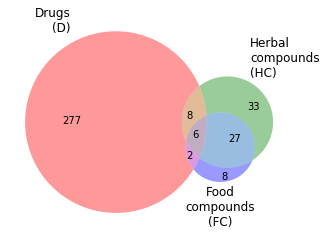

In [25]:
venn3((277,33,8,8,2,27,6), set_labels = ('Drugs\n(D)', 'Herbal\ncompounds\n(HC)', 'Food\ncompounds\n(FC)'))

In [26]:
FC_tm2 = FC_tm[~FC_tm.isin(D_FC_common)].dropna()
FC_tm2.reset_index(drop=True).head()

,UniProtKB,Protein,Accession,Class,Units,FC,InChIKey,Affinity.FC,Metabolite,Affinity.metabolite
0,ESR2_HUMAN,Estrogen receptor beta,Q92731,Nuclear hormone receptor,Ki,ESTRADIOL,VOXZDWNPVJITMN-ZBRFXRBCSA-N,9.59,17β-estradiol,9.34
1,ESR2_HUMAN,Estrogen receptor beta,Q92731,Nuclear hormone receptor,Ki,GENISTEIN,TZBJGXHYKVUXJN-UHFFFAOYSA-N,8.42,17β-estradiol,9.34
2,ESR2_HUMAN,Estrogen receptor beta,Q92731,Nuclear hormone receptor,Ki,DAIDZEIN,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,6.52,17β-estradiol,9.34
3,ESR2_HUMAN,Estrogen receptor beta,Q92731,Nuclear hormone receptor,Ki,EMODIN,RHMXXJGYXNZAPX-UHFFFAOYSA-N,5.82,17β-estradiol,9.34
4,5HT2C_HUMAN,Serotonin 2c (5-HT2c) receptor,P28335,GPCR,Ki,SEROTONIN,QZAYGJVTTNCVMB-UHFFFAOYSA-N,7.42,5-hydroxytryptamine,8.60


In [27]:
HC_tm2 = HC_tm[~HC_tm.isin(D_HC_FC_common)].dropna()
HC_tm2.reset_index(drop=True).head()

,UniProtKB,Protein,Accession,Class,Units,HC.db,HC.chembl,InChIKey,Affinity.HC,Metabolite,Affinity.metabolite
0,5HT1A_HUMAN,Serotonin 1a (5-HT1a) receptor,P08908,GPCR,Ki,SYNEPHRINE|SYNEPHERINE,OXEDRINE,YRCWQPVGYLYSOX-UHFFFAOYSA-N,4.20,5-hydroxytryptamine,9.7
1,ACM4_HUMAN,Muscarinic acetylcholine receptor M4,P08173,GPCR,Ki,MUSCARINE,MUSCARINE,UQOFGTXDASPNLL-XHNCKOQMSA-N,6.01,acetylcholine,5.6
2,ACM2_HUMAN,Muscarinic acetylcholine receptor M2,P08172,GPCR,Ki,MUSCARINE,MUSCARINE,UQOFGTXDASPNLL-XHNCKOQMSA-N,7.04,acetylcholine,6.5
3,ACM1_HUMAN,Muscarinic acetylcholine receptor M1,P11229,GPCR,Ki,MUSCARINE,MUSCARINE,UQOFGTXDASPNLL-XHNCKOQMSA-N,6.00,acetylcholine,4.9
4,OPRM_HUMAN,Mu opioid receptor,P35372,GPCR,Ki,SINOACUTINE|SALUTARIDINE,SALUTARIDINE,GVTRUVGBZQJVTF-YJYMSZOUSA-N,4.46,[Leu]enkephalin,8.1


In [28]:
#FC_tm2.to_csv('FC_target_metabolite2.csv', sep='\t', index=False)
#HC_tm2.to_csv('HC_target_metabolite2.csv', sep='\t', index=False)

In [29]:
len(FC_tm2)

119

### Affinity plots

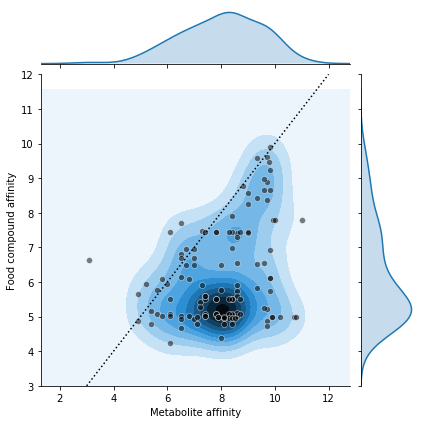

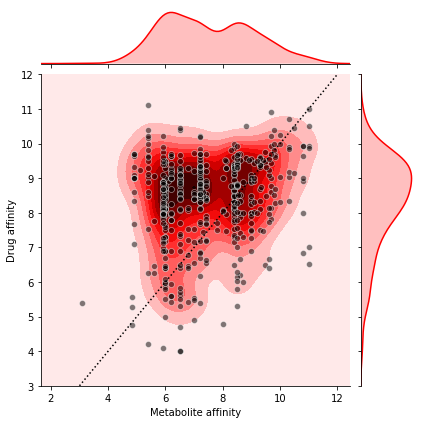

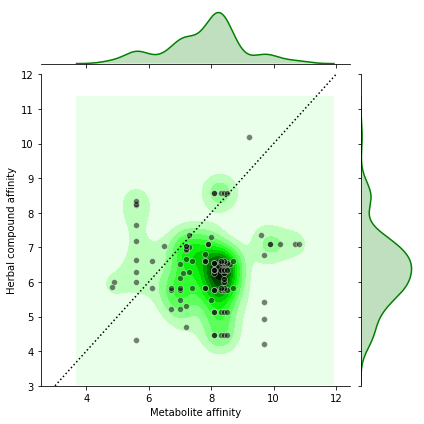

In [140]:
g1 = (sns.jointplot(x="Affinity.metabolite", y="Affinity.FC", data=FC_tm2, 
                    kind='kde', ylim=(3,12)).plot_joint(sns.scatterplot, color='k', alpha=0.5))
x0, x1 = g1.ax_joint.get_xlim()
y0, y1 = g1.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g1.ax_joint.plot(lims, lims, ':k')
g1.set_axis_labels('Metabolite affinity', 'Food compound affinity')
g2 = (sns.jointplot("Affinity.metabolite", "Affinity.drug", data=drug_tm, kind='kde',
                    color='red', ylim=(3,12)).plot_joint(sns.scatterplot, color='k', alpha=0.5))
g2.ax_joint.plot(lims, lims, ':k')
g2.set_axis_labels('Metabolite affinity', 'Drug affinity')
g3 = (sns.jointplot("Affinity.metabolite", "Affinity.HC", data=HC_tm2, kind='kde',
                    color='green', ylim=(3,12)).plot_joint(sns.scatterplot, color='k', alpha=0.5))
g3.ax_joint.plot(lims, lims, ':k')
g3.set_axis_labels('Metabolite affinity', 'Herbal compound affinity')
plt.show()

# Chemical analysis

### Chemical properties and structures

#### Drugs

To search drug properties, the InChIKeys were extracted from *drug_tm* table and then searched on ChEMBL to obtain the molecular weight, the ALogP and the Smiles of each molecule.

In [31]:
drug_prop = pd.read_csv('drugs_mw_logp.csv', sep='\t')
drug_prop.columns = ['InChIKey', 'Smiles', 'MW', 'ALogP']
drug_prop.head()

,InChIKey,Smiles,MW,ALogP
0,ACCMWZWAEFYUGZ-UHFFFAOYSA-N,CCOCCn1c(nc2ccccc12)C3CCN(CCc4ccc(cc4)C(C)(C)C(=O)O)CC3,463.62,4.86
1,ADXGNEYLLLSOAR-UHFFFAOYSA-N,Cc1nc(C)c2CCC(=O)N(Cc3ccc(cc3)c4ccccc4c5nn[nH]n5)c2n1,411.47,3.42
2,AIWRTTMUVOZGPW-HSPKUQOVSA-N,CC(C)C[C@H](NC(=O)[C@@H](CC(=O)N)NC(=O)[C@H](Cc1ccc(O)cc1)N(C)C(=O)[C@H](CO)NC(=O)[C@@H](Cc2cccnc2)NC(=O)[C@@H](Cc3ccc(Cl)cc3)NC(=O)[C@@H](Cc4ccc5ccccc5c4)NC(=O)C)C(=O)N[C@@H](CCCCNC(C)C)C(=O)N6CCC[C@H]6C(=O)N[C@H](C)C(=O)N,1416.09,NaN
3,AMEROGPZOLAFBN-UHFFFAOYSA-N,CCCCC1=NC(=C(CC(=S)N(C)C)C(=O)N1Cc2ccc(cc2)c3ccccc3c4nnn[nH]4)C,501.66,4.22
4,AMKVXSZCKVJAGH-UHFFFAOYSA-N,CNS(=O)(=O)CCc1ccc2[nH]cc(C3CCN(C)CC3)c2c1,335.47,2.07


,InChIKey,Smiles,MW,ALogP,ROMol,Murcko_SMILES
0,ACCMWZWAEFYUGZ-UHFFFAOYSA-N,CCOCCn1c(nc2ccccc12)C3CCN(CCc4ccc(cc4)C(C)(C)C(=O)O)CC3,463.62,4.86,,c1ccc(CCN2CCC(c3nc4ccccc4[nH]3)CC2)cc1
1,ADXGNEYLLLSOAR-UHFFFAOYSA-N,Cc1nc(C)c2CCC(=O)N(Cc3ccc(cc3)c4ccccc4c5nn[nH]n5)c2n1,411.47,3.42,,O=C1CCc2cncnc2N1Cc1ccc(-c2ccccc2-c2nn[nH]n2)cc1
2,AIWRTTMUVOZGPW-HSPKUQOVSA-N,CC(C)C[C@H](NC(=O)[C@@H](CC(=O)N)NC(=O)[C@H](Cc1ccc(O)cc1)N(C)C(=O)[C@H](CO)NC(=O)[C@@H](Cc2cccnc2)NC(=O)[C@@H](Cc3ccc(Cl)cc3)NC(=O)[C@@H](Cc4ccc5ccccc5c4)NC(=O)C)C(=O)N[C@@H](CCCCNC(C)C)C(=O)N6CCC[C@H]6C(=O)N[C@H](C)C(=O)N,1416.09,NaN,,O=C(CNC(=O)CNC(=O)C(Cc1ccccc1)NC(=O)CNC(=O)C(Cc1cccnc1)NC(=O)C(Cc1ccccc1)NC(=O)CCc1ccc2ccccc2c1)NCC(=O)N1CCCC1
3,AMEROGPZOLAFBN-UHFFFAOYSA-N,CCCCC1=NC(=C(CC(=S)N(C)C)C(=O)N1Cc2ccc(cc2)c3ccccc3c4nnn[nH]4)C,501.66,4.22,,O=c1ccncn1Cc1ccc(-c2ccccc2-c2nnn[nH]2)cc1
4,AMKVXSZCKVJAGH-UHFFFAOYSA-N,CNS(=O)(=O)CCc1ccc2[nH]cc(C3CCN(C)CC3)c2c1,335.47,2.07,,c1ccc2c(C3CCNCC3)c[nH]c2c1

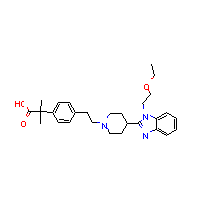
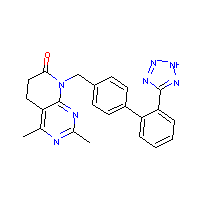
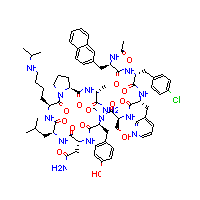
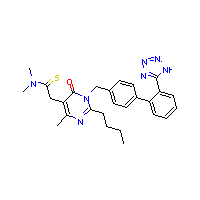
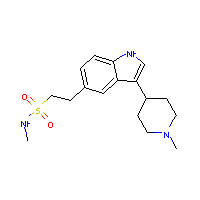

In [32]:
PandasTools.AddMoleculeColumnToFrame(drug_prop, smilesCol='Smiles', molCol='ROMol')
PandasTools.AddMurckoToFrame(drug_prop, molCol='ROMol', MurckoCol='Murcko_SMILES', Generic=False)
drug_prop.head()

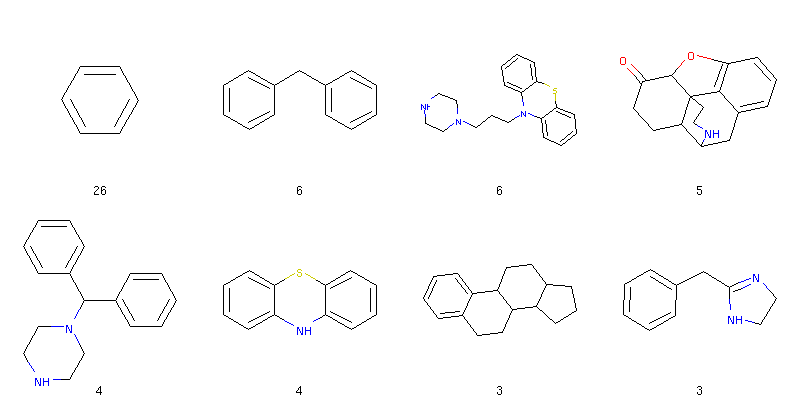

In [33]:
drug_scaffolds = drug_prop.groupby(['Murcko_SMILES']).count()
drug_scaffolds = drug_scaffolds[['InChIKey']].rename(columns={'InChIKey':'Count'})
drug_scaffolds = drug_scaffolds.sort_values(by='Count', ascending=False).reset_index()
PandasTools.AddMoleculeColumnToFrame(drug_scaffolds, smilesCol='Murcko_SMILES', molCol='ROMol')
PandasTools.FrameToGridImage(drug_scaffolds.dropna().head(8), legendsCol='Count', molsPerRow=4)

In [34]:
len(drug_scaffolds)

209

#### Metabolites

First we need to gather all metabolites recorded in all three affinity datasets to after search them in GtoPdb and obtain their InChIKey to finally map it to ChEMBL and gather the molecular weight, the ALogP and the Smiles for each molecule.

In [35]:
met_names = set(drug_tm['Metabolite']) | set(HC_tm2['Metabolite']) | set(FC_tm2['Metabolite'])

In [36]:
#with open('met_list.txt', 'w') as f:
#    for elem in met_names:
#        f.write(elem+'\n')

In [37]:
met_inchikey = pd.read_csv('ligand_inchikey.csv',sep='\t')
met_inchikey.head()

,Metabolite,InChIKey
0,tyramine,DZGWFCGJZKJUFP-UHFFFAOYSA-N
1,ADP,XTWYTFMLZFPYCI-KQYNXXCUSA-N
2,substance P,ADNPLDHMAVUMIW-CUZNLEPHSA-N
3,GnRH I,NMJREATYWWNIKX-UHFFFAOYSA-N
4,5-hydroxytryptamine,QZAYGJVTTNCVMB-UHFFFAOYSA-N


Remove metabolites that are also drugs:

In [38]:
D_M_common = set(pd.merge(drug_tm, met_inchikey, on=['InChIKey'])['InChIKey'])
D_M_common

{'AUYYCJSJGJYCDS-LBPRGKRZSA-N',
 'DZGWFCGJZKJUFP-UHFFFAOYSA-N',
 'KAQKFAOMNZTLHT-OZUDYXHBSA-N',
 'KBZOIRJILGZLEJ-LGYYRGKSSA-N',
 'MASNOZXLGMXCHN-ZLPAWPGGSA-N',
 'NTYJJOPFIAHURM-UHFFFAOYSA-N',
 'SFLSHLFXELFNJZ-QMMMGPOBSA-N',
 'UCTWMZQNUQWSLP-VIFPVBQESA-N',
 'VYFYYTLLBUKUHU-UHFFFAOYSA-N',
 'XNOPRXBHLZRZKH-DSZYJQQASA-N'}

In [39]:
met_inchikey2 = met_inchikey[~met_inchikey.isin(D_M_common)].dropna()
met_inchikey2.reset_index(drop=True).head()

,Metabolite,InChIKey
0,ADP,XTWYTFMLZFPYCI-KQYNXXCUSA-N
1,substance P,ADNPLDHMAVUMIW-CUZNLEPHSA-N
2,GnRH I,NMJREATYWWNIKX-UHFFFAOYSA-N
3,5-hydroxytryptamine,QZAYGJVTTNCVMB-UHFFFAOYSA-N
4,aldosterone,PQSUYGKTWSAVDQ-ZVIOFETBSA-N


In [40]:
#with open('met_inchikey_list.txt', 'w') as f:
#    for elem in met_inchikey2['InChIKey']:
#        f.write(elem+'\n')

In [41]:
met_prop = pd.read_csv('met_prop.csv', sep='\t')
met_prop.columns = ['InChIKey', 'MW', 'ALogP', 'Smiles']
met_prop.head()

,InChIKey,MW,ALogP,Smiles
0,ADNPLDHMAVUMIW-CUZNLEPHSA-N,1347.66,NaN,CSCC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)CNC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@@H]3CCCN3C(=O)[C@H](CCCCN)NC(=O)[C@@H]4CCCN4C(=O)[C@@H](N)CCCN=C(N)N)C(=O)N
1,AGTSSZRZBSNTGQ-ITZCFHCWSA-N,1570.86,NaN,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)[C@@H](N)Cc2ccc(O)cc2)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](Cc3ccccc3)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H]([C@@H](C)O)C(=O)O
2,BHHGXPLMPWCGHP-UHFFFAOYSA-N,121.18,1.19,NCCc1ccccc1
3,CZGUSIXMZVURDU-JZXHSEFVSA-N,1046.20,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](N)CC(=O)O)C(C)C)C(=O)N[C@@H](Cc2cnc[nH]2)C(=O)N3CCC[C@H]3C(=O)N[C@@H](Cc4ccccc4)C(=O)O
4,DRLFMBDRBRZALE-UHFFFAOYSA-N,232.28,1.86,COc1ccc2[nH]cc(CCNC(=O)C)c2c1


Murcko scaffolds:

,InChIKey,MW,ALogP,Smiles,ROMol,Murcko_SMILES
0,ADNPLDHMAVUMIW-CUZNLEPHSA-N,1347.66,NaN,CSCC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)CNC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@@H]3CCCN3C(=O)[C@H](CCCCN)NC(=O)[C@@H]4CCCN4C(=O)[C@@H](N)CCCN=C(N)N)C(=O)N,,O=C(CNC(=O)C1CCCN1C(=O)CNC(=O)C1CCCN1)NCC(=O)NC(Cc1ccccc1)C(=O)NCCc1ccccc1
1,AGTSSZRZBSNTGQ-ITZCFHCWSA-N,1570.86,NaN,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)[C@@H](N)Cc2ccc(O)cc2)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](Cc3ccccc3)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H]([C@@H](C)O)C(=O)O,,O=C(CCc1ccccc1)NCC(=O)NCC(=O)NC(Cc1ccccc1)C(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCCc1ccccc1
2,BHHGXPLMPWCGHP-UHFFFAOYSA-N,121.18,1.19,NCCc1ccccc1,,c1ccccc1
3,CZGUSIXMZVURDU-JZXHSEFVSA-N,1046.20,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](N)CC(=O)O)C(C)C)C(=O)N[C@@H](Cc2cnc[nH]2)C(=O)N3CCC[C@H]3C(=O)N[C@@H](Cc4ccccc4)C(=O)O,,O=C(CCc1ccccc1)NCC(=O)NC(Cc1cnc[nH]1)C(=O)N1CCCC1C(=O)NCCc1ccccc1
4,DRLFMBDRBRZALE-UHFFFAOYSA-N,232.28,1.86,COc1ccc2[nH]cc(CCNC(=O)C)c2c1,,c1ccc2[nH]ccc2c1

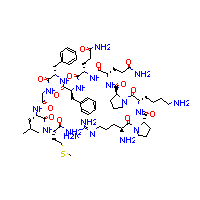
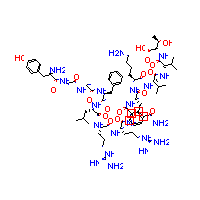
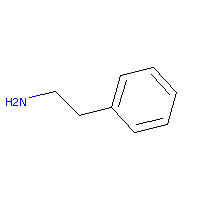
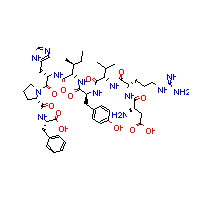
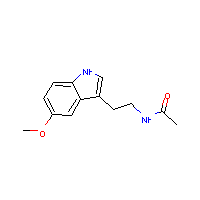

In [42]:
PandasTools.AddMoleculeColumnToFrame(met_prop, smilesCol='Smiles', molCol='ROMol')
PandasTools.AddMurckoToFrame(met_prop, molCol='ROMol', MurckoCol='Murcko_SMILES', Generic=False)
met_prop.head()

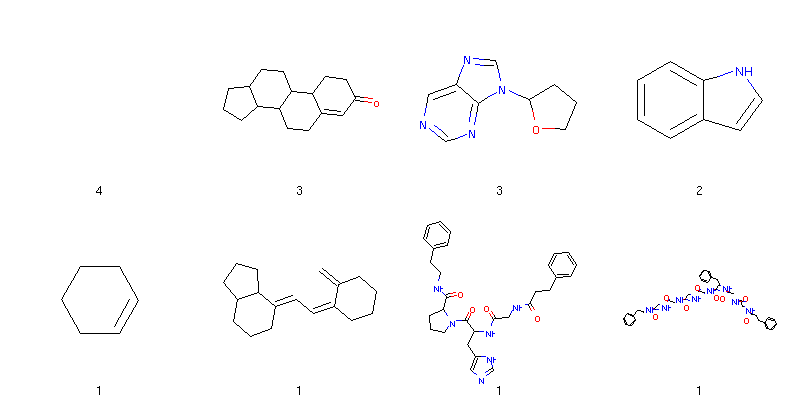

In [43]:
met_scaffolds = met_prop.groupby(['Murcko_SMILES']).count()
met_scaffolds = met_scaffolds[['InChIKey']].rename(columns={'InChIKey':'Count'})
met_scaffolds = met_scaffolds.sort_values(by='Count', ascending=False).reset_index()
PandasTools.AddMoleculeColumnToFrame(met_scaffolds, smilesCol='Murcko_SMILES', molCol='ROMol')
PandasTools.FrameToGridImage(met_scaffolds.dropna().head(8), legendsCol='Count', molsPerRow=4)

In [44]:
len(met_scaffolds)

13

#### Food and herbal compounds - Natural compounds
Molecular properties:

In [45]:
NC_inchikey = set(HC_tm2['InChIKey']).union(set(FC_tm2['InChIKey']))
#with open('NC_inchikey.txt', 'w') as f:
#    for elem in NC_inchikey:
#        f.write(elem + '\n')

The previous InChIKeys are mapped into ChEMBL in order to obtain their corresponding molecular weight, the ALogP and the Smiles. The results are in file *NC_prop.csv*.

In [46]:
NC_prop = pd.read_csv('NC_prop.csv', sep='\t')
NC_prop.columns = ['InChIKey', 'MW', 'ALogP', 'Smiles']
NC_prop.head()

,InChIKey,MW,ALogP,Smiles
0,AEQDJSLRWYMAQI-KRWDZBQOSA-N,355.43,3.38,COc1cc2CCN3Cc4c(C[C@H]3c2cc1OC)ccc(OC)c4OC
1,AIULWNKTYPZYAN-SFHVURJKSA-N,350.50,4.79,CCCCCCCCC[C@H](O)CC(=O)CCc1ccc(O)c(OC)c1
2,APJYDQYYACXCRM-UHFFFAOYSA-N,160.22,1.67,NCCc1c[nH]c2ccccc12
3,ASUSBMNYRHGZIG-UHFFFAOYSA-N,190.25,1.64,CNCCc1c[nH]c2ccc(O)cc12
4,BCIWKKMTBRYQJU-INIZCTEOSA-N,322.45,4.01,CCCCCCC[C@H](O)CC(=O)CCc1ccc(O)c(OC)c1


Remove natural compounds that are also metabolites:

In [47]:
NC_M_common = set(pd.merge(NC_prop, met_inchikey2, on=['InChIKey'])['InChIKey'])
NC_M_common

{'BHHGXPLMPWCGHP-UHFFFAOYSA-N',
 'DRLFMBDRBRZALE-UHFFFAOYSA-N',
 'GMRQFYUYWCNGIN-NKMMMXOESA-N',
 'OIPILFWXSMYKGL-UHFFFAOYSA-N',
 'OIRDTQYFTABQOQ-KQYNXXCUSA-N',
 'QZAYGJVTTNCVMB-UHFFFAOYSA-N',
 'RJKFOVLPORLFTN-LEKSSAKUSA-N',
 'VOXZDWNPVJITMN-ZBRFXRBCSA-N'}

In [48]:
NC_prop2 = NC_prop[~NC_prop.isin(NC_M_common)].dropna()
NC_prop2.reset_index(drop=True).head()

,InChIKey,MW,ALogP,Smiles
0,AEQDJSLRWYMAQI-KRWDZBQOSA-N,355.43,3.38,COc1cc2CCN3Cc4c(C[C@H]3c2cc1OC)ccc(OC)c4OC
1,AIULWNKTYPZYAN-SFHVURJKSA-N,350.50,4.79,CCCCCCCCC[C@H](O)CC(=O)CCc1ccc(O)c(OC)c1
2,APJYDQYYACXCRM-UHFFFAOYSA-N,160.22,1.67,NCCc1c[nH]c2ccccc12
3,ASUSBMNYRHGZIG-UHFFFAOYSA-N,190.25,1.64,CNCCc1c[nH]c2ccc(O)cc12
4,BCIWKKMTBRYQJU-INIZCTEOSA-N,322.45,4.01,CCCCCCC[C@H](O)CC(=O)CCc1ccc(O)c(OC)c1


Murcko scaffolds:

,InChIKey,MW,ALogP,Smiles,ROMol,Murcko_SMILES
0,AEQDJSLRWYMAQI-KRWDZBQOSA-N,355.43,3.38,COc1cc2CCN3Cc4c(C[C@H]3c2cc1OC)ccc(OC)c4OC,,c1ccc2c(c1)CC1c3ccccc3CCN1C2
1,AIULWNKTYPZYAN-SFHVURJKSA-N,350.50,4.79,CCCCCCCCC[C@H](O)CC(=O)CCc1ccc(O)c(OC)c1,,c1ccccc1
2,APJYDQYYACXCRM-UHFFFAOYSA-N,160.22,1.67,NCCc1c[nH]c2ccccc12,,c1ccc2[nH]ccc2c1
3,ASUSBMNYRHGZIG-UHFFFAOYSA-N,190.25,1.64,CNCCc1c[nH]c2ccc(O)cc12,,c1ccc2[nH]ccc2c1
4,BCIWKKMTBRYQJU-INIZCTEOSA-N,322.45,4.01,CCCCCCC[C@H](O)CC(=O)CCc1ccc(O)c(OC)c1,,c1ccccc1

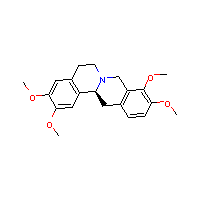
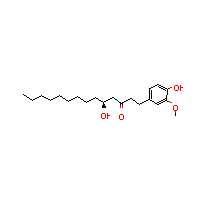
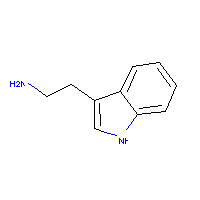
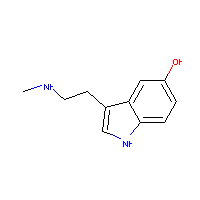
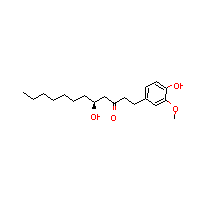

In [49]:
PandasTools.AddMoleculeColumnToFrame(NC_prop2, smilesCol='Smiles', molCol='ROMol')
PandasTools.AddMurckoToFrame(NC_prop2, molCol='ROMol', MurckoCol='Murcko_SMILES', Generic=False)
NC_prop2.head()

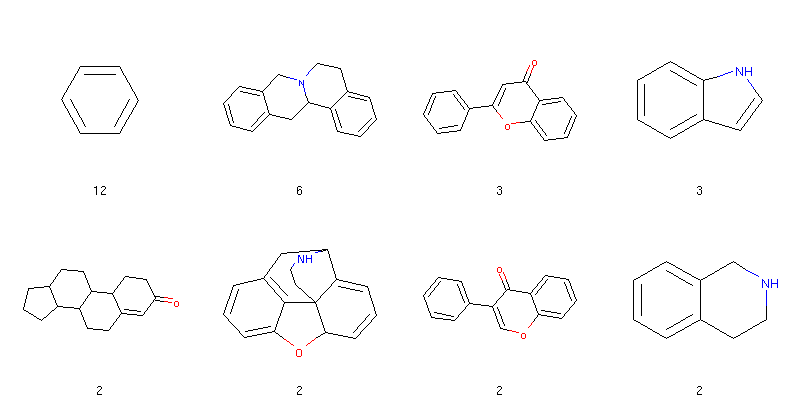

In [50]:
NC_scaffolds = NC_prop2.groupby(['Murcko_SMILES']).count()
NC_scaffolds = NC_scaffolds[['InChIKey']].rename(columns={'InChIKey':'Count'})
NC_scaffolds = NC_scaffolds.sort_values(by='Count', ascending=False).reset_index()
PandasTools.AddMoleculeColumnToFrame(NC_scaffolds, smilesCol='Murcko_SMILES', molCol='ROMol')
PandasTools.FrameToGridImage(NC_scaffolds.dropna().head(8), legendsCol='Count', molsPerRow=4)

In [51]:
len(NC_scaffolds)

36

In [116]:
met_scaffolds['Count']

0     4
1     3
2     3
3     2
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
Name: Count, dtype: int64

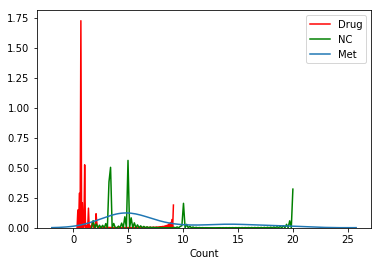

In [119]:
sns.distplot(drug_scaffolds['Count']/285*100, label='Drug', color='r', hist=False)
sns.distplot(NC_scaffolds['Count']/60*100, label='NC', color='g', hist=False)
sns.distplot(met_scaffolds['Count']/21*100, label='Met', hist=False)
plt.legend()

#### Venn diagram of the common compounds:

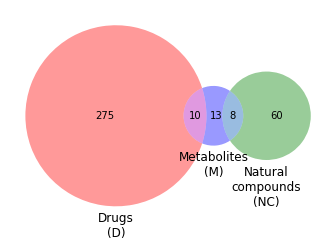

In [52]:
venn3((275,60,0,13,10,8,0), set_labels = ('Drugs\n(D)', 'Natural\ncompounds\n(NC)', 'Metabolites\n(M)'))

### Properties analysis

- Molecular weight distribution:

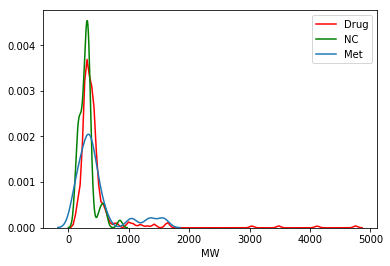

In [53]:
sns.distplot(drug_prop['MW'], label = 'Drug', color='r', hist=False)
sns.distplot(NC_prop2['MW'], label = 'NC', color='g', hist=False)
sns.distplot(met_prop['MW'], label = 'Met', hist=False)
plt.legend()
plt.show()

- ALogP distribution:

/home/mpique/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mpique/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


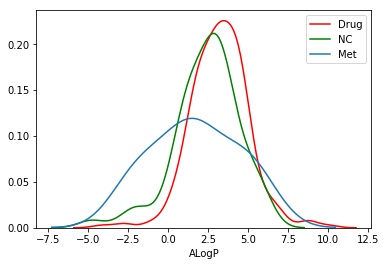

In [54]:
sns.distplot(drug_prop['ALogP'], label = 'Drug', color='r', hist=False)
sns.distplot(NC_prop2['ALogP'], label = 'NC', color='g', hist=False)
sns.distplot(met_prop['ALogP'], label = 'Met', hist=False)
plt.legend()
plt.show()

- Molecular weight vs ALogP:

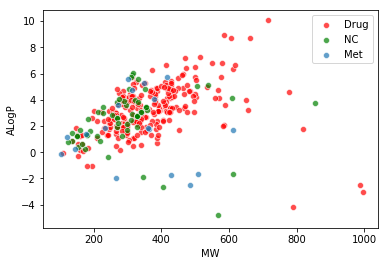

In [55]:
sns.scatterplot(drug_prop['MW'], drug_prop['ALogP'], label = 'Drug', color='r', alpha=0.7)
sns.scatterplot(NC_prop2['MW'], NC_prop2['ALogP'], label = 'NC', color='g', alpha=0.7)
sns.scatterplot(met_prop['MW'], met_prop['ALogP'], label = 'Met', alpha=0.7)
plt.legend()
plt.show()

### Ring analysis

The following module *MyMol* was developed by our lab.

In [58]:
from MyMol import MyMol

In [59]:
NC_rings = np.zeros(len(NC_prop2))
for i in range(len(NC_prop2)):
    m = MyMol(NC_prop2.iat[i,4])
    NC_rings[i] = m.get_n_rings()

In [60]:
drug_rings = np.zeros(len(drug_prop))
for i in range(len(drug_prop)):
    m = MyMol(drug_prop.iat[i,4])
    drug_rings[i] = m.get_n_rings()

In [61]:
met_rings = np.zeros(len(met_prop))
for i in range(len(met_prop)):
    m = MyMol(met_prop.iat[i,4])
    met_rings[i] = m.get_n_rings()

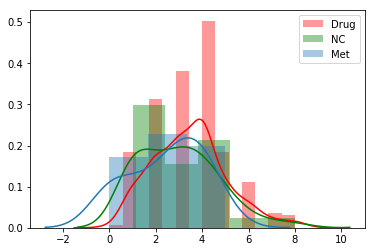

In [62]:
sns.distplot(drug_rings, label = 'Drug', color='r')
sns.distplot(NC_rings, label = 'NC', color='g')
sns.distplot(met_rings, label = 'Met')
plt.legend()
plt.show()

#### Creating unique chemical dataset

InChIKey                                                                                                                                                                                                                           Smiles       MW  ALogP                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
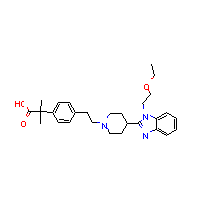
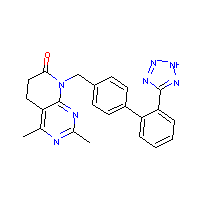
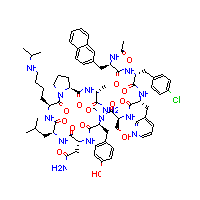
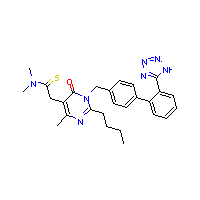
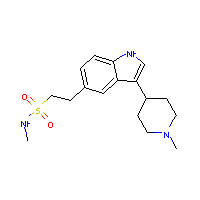

In [63]:
chem_ds = pd.concat([drug_prop, NC_prop2, met_prop], keys=['D','NC','M'], sort=False)
chem_ds.head()

In [64]:
#chem_ds.to_csv('chem_ds.csv', sep='\t')

### Similarity analysis

In [65]:
def similarity_matrix(fps1, fps2):
    SM = np.zeros((len(fps1), len(fps2)))
    for i in range(len(fps1)):
        for j in range(len(fps2)):
            SM[i][j] = DataStructs.FingerprintSimilarity(fps1[i],fps2[j])
    return(SM)

In [66]:
ms_NC = NC_prop2['Smiles'].tolist()
fps_NC = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)) for x in ms_NC]

In [67]:
ms_drug = drug_prop['Smiles'].tolist()
fps_drug = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)) for x in ms_drug]

In [68]:
ms_met = met_prop['Smiles'].tolist()
fps_met = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)) for x in ms_met]

In [69]:
fps_all = fps_drug + fps_NC + fps_met

- Drugs vs Drugs

In [70]:
SM_drug = similarity_matrix(fps_drug, fps_drug)
SM_drug

array([[1.        , 0.5890411 , 0.56470588, ..., 0.54545455, 0.56060606,
        0.45901639],
       [0.5890411 , 1.        , 0.54651163, ..., 0.37837838, 0.39189189,
        0.30882353],
       [0.56470588, 0.54651163, 1.        , ..., 0.52564103, 0.5       ,
        0.37662338],
       ...,
       [0.54545455, 0.37837838, 0.52564103, ..., 1.        , 0.58928571,
        0.47058824],
       [0.56060606, 0.39189189, 0.5       , ..., 0.58928571, 1.        ,
        0.58333333],
       [0.45901639, 0.30882353, 0.37662338, ..., 0.47058824, 0.58333333,
        1.        ]])

In [71]:
pd.DataFrame(SM_drug).to_csv('SM_drug.csv', sep=',', index=False)

- NC vs NC

In [72]:
SM_NC = similarity_matrix(fps_NC, fps_NC)
SM_NC

array([[1.        , 0.42857143, 0.28571429, ..., 0.37735849, 0.63793103,
        0.4       ],
       [0.42857143, 1.        , 0.18518519, ..., 0.38297872, 0.38095238,
        0.40909091],
       [0.28571429, 0.18518519, 1.        , ..., 0.16326531, 0.27419355,
        0.17391304],
       ...,
       [0.37735849, 0.38297872, 0.16326531, ..., 1.        , 0.33333333,
        0.89655172],
       [0.63793103, 0.38095238, 0.27419355, ..., 0.33333333, 1.        ,
        0.32758621],
       [0.4       , 0.40909091, 0.17391304, ..., 0.89655172, 0.32758621,
        1.        ]])

In [73]:
pd.DataFrame(SM_NC).to_csv('SM_NC.csv', sep=',', index=False)

- Met vs Met

In [74]:
SM_met = similarity_matrix(fps_met, fps_met)
SM_met

array([[1.        , 0.68055556, 0.23809524, 0.78666667, 0.46575342,
        0.35443038, 0.30379747, 0.33333333, 0.43478261, 0.35211268,
        0.45783133, 0.42222222, 0.3164557 , 0.36111111, 0.25333333,
        0.20833333, 0.26666667, 0.14492754, 0.43956044, 0.625     ,
        0.43956044],
       [0.68055556, 1.        , 0.25862069, 0.79166667, 0.47826087,
        0.41666667, 0.4       , 0.43055556, 0.49206349, 0.3       ,
        0.43209877, 0.4137931 , 0.375     , 0.43076923, 0.27142857,
        0.24242424, 0.34328358, 0.27586207, 0.41573034, 0.57746479,
        0.41573034],
       [0.23809524, 0.25862069, 1.        , 0.21126761, 0.31111111,
        0.20408163, 0.12244898, 0.15384615, 0.275     , 0.2       ,
        0.15873016, 0.11111111, 0.16666667, 0.42857143, 0.0952381 ,
        0.11428571, 0.14634146, 0.06896552, 0.12162162, 0.25454545,
        0.12162162],
       [0.78666667, 0.79166667, 0.21126761, 1.        , 0.49350649,
        0.36904762, 0.35365854, 0.38095238, 0.4266666

In [75]:
pd.DataFrame(SM_met).to_csv('SM_met.csv', sep=',', index=False)

- Drug vs NC

In [76]:
SM_drug_NC = similarity_matrix(fps_drug, fps_NC)
SM_drug_NC

array([[0.54545455, 0.32394366, 0.32307692, ..., 0.27941176, 0.55714286,
        0.27272727],
       [0.45714286, 0.25333333, 0.34375   , ..., 0.24285714, 0.43421053,
        0.23529412],
       [0.50632911, 0.40506329, 0.37333333, ..., 0.33333333, 0.46511628,
        0.29487179],
       ...,
       [0.46666667, 0.26984127, 0.35849057, ..., 0.19672131, 0.43939394,
        0.18644068],
       [0.43548387, 0.35      , 0.30357143, ..., 0.17460317, 0.52380952,
        0.16393443],
       [0.47058824, 0.31372549, 0.25531915, ..., 0.15384615, 0.4137931 ,
        0.16326531]])

In [77]:
pd.DataFrame(SM_drug_NC).to_csv('SM_drug_NC.csv', sep=',', index=False)

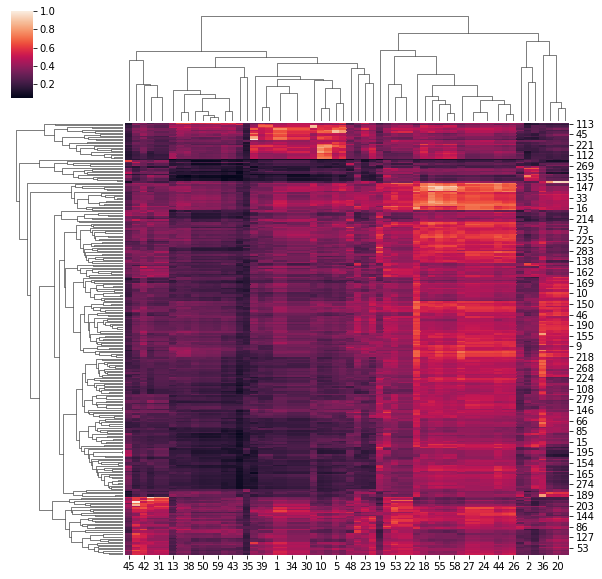

In [78]:
sns.clustermap(SM_drug_NC)

- Drug vs Metabolite

In [79]:
SM_drug_met = similarity_matrix(fps_drug, fps_met)
SM_drug_met

array([[0.53164557, 0.39759036, 0.17741935, ..., 0.43181818, 0.51351351,
        0.43181818],
       [0.47560976, 0.34883721, 0.19672131, ..., 0.5       , 0.53424658,
        0.5       ],
       [0.6626506 , 0.62195122, 0.2       , ..., 0.55434783, 0.72      ,
        0.55434783],
       ...,
       [0.46575342, 0.37837838, 0.2826087 , ..., 0.34939759, 0.48484848,
        0.34939759],
       [0.52112676, 0.4109589 , 0.25      , ..., 0.29885057, 0.45588235,
        0.29885057],
       [0.40298507, 0.34848485, 0.31428571, ..., 0.22222222, 0.30769231,
        0.22222222]])

In [80]:
pd.DataFrame(SM_drug_met).to_csv('SM_drug_met.csv', sep=',', index=False)

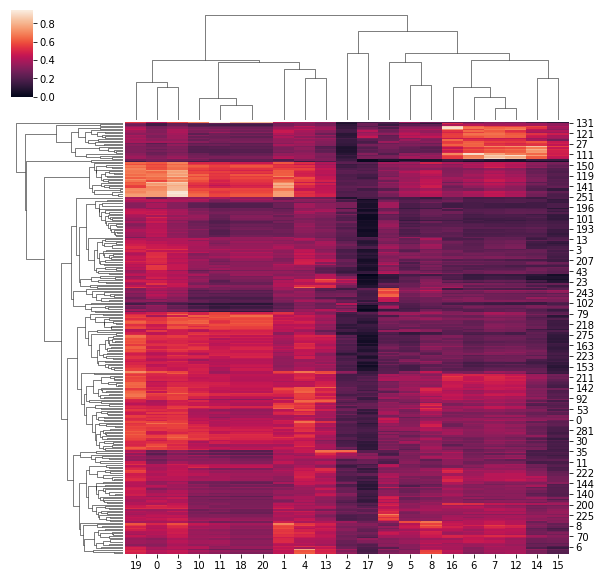

In [81]:
sns.clustermap(SM_drug_met)

- NC vs metabolite

In [82]:
SM_NC_met = similarity_matrix(fps_NC, fps_met)
SM_NC_met

array([[0.40789474, 0.37837838, 0.20408163, ..., 0.33333333, 0.48484848,
        0.33333333],
       [0.32      , 0.42424242, 0.15909091, ..., 0.25301205, 0.36363636,
        0.25301205],
       [0.37878788, 0.32307692, 0.53571429, ..., 0.2972973 , 0.49090909,
        0.2972973 ],
       ...,
       [0.19480519, 0.29850746, 0.07317073, ..., 0.34722222, 0.38333333,
        0.34722222],
       [0.3902439 , 0.31325301, 0.17857143, ..., 0.35227273, 0.47887324,
        0.35227273],
       [0.17105263, 0.27272727, 0.07894737, ..., 0.30555556, 0.3559322 ,
        0.30555556]])

In [83]:
pd.DataFrame(SM_NC_met).to_csv('SM_NC_met.csv', sep=',', index=False)

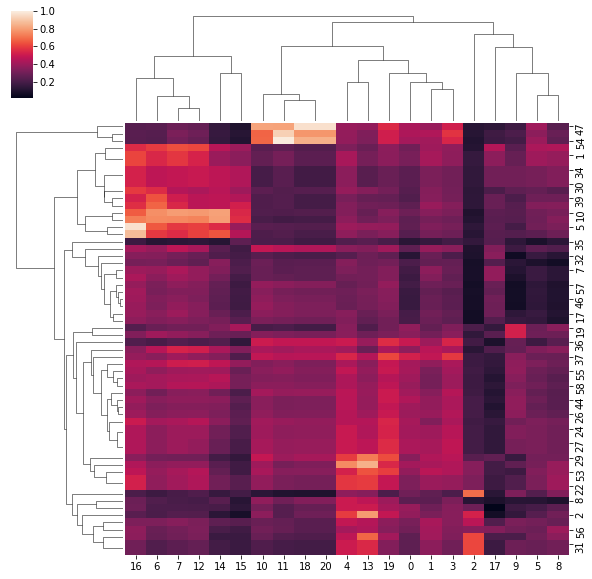

In [84]:
sns.clustermap(SM_NC_met)

- All vs all

In [85]:
SM_all = similarity_matrix(fps_all, fps_all)
SM_all

array([[1.        , 0.5890411 , 0.56470588, ..., 0.43181818, 0.51351351,
        0.43181818],
       [0.5890411 , 1.        , 0.54651163, ..., 0.5       , 0.53424658,
        0.5       ],
       [0.56470588, 0.54651163, 1.        , ..., 0.55434783, 0.72      ,
        0.55434783],
       ...,
       [0.43181818, 0.5       , 0.55434783, ..., 1.        , 0.56410256,
        1.        ],
       [0.51351351, 0.53424658, 0.72      , ..., 0.56410256, 1.        ,
        0.56410256],
       [0.43181818, 0.5       , 0.55434783, ..., 1.        , 0.56410256,
        1.        ]])

In [86]:
pd.DataFrame(SM_all).to_csv('SM_all.csv', sep=',', index=False)

In [87]:
print(len(fps_drug),len(fps_NC),len(fps_met),len(fps_all))

285 60 21 366


# SOM implementation with python using SimpSOM library

In [88]:
net = sps.somNet(10, 10, SM_all, PBC=True)

Periodic Boundary Conditions active.
The weights will be initialised randomly.


In [89]:
net.train(0.01, 1000)

Training SOM... done!


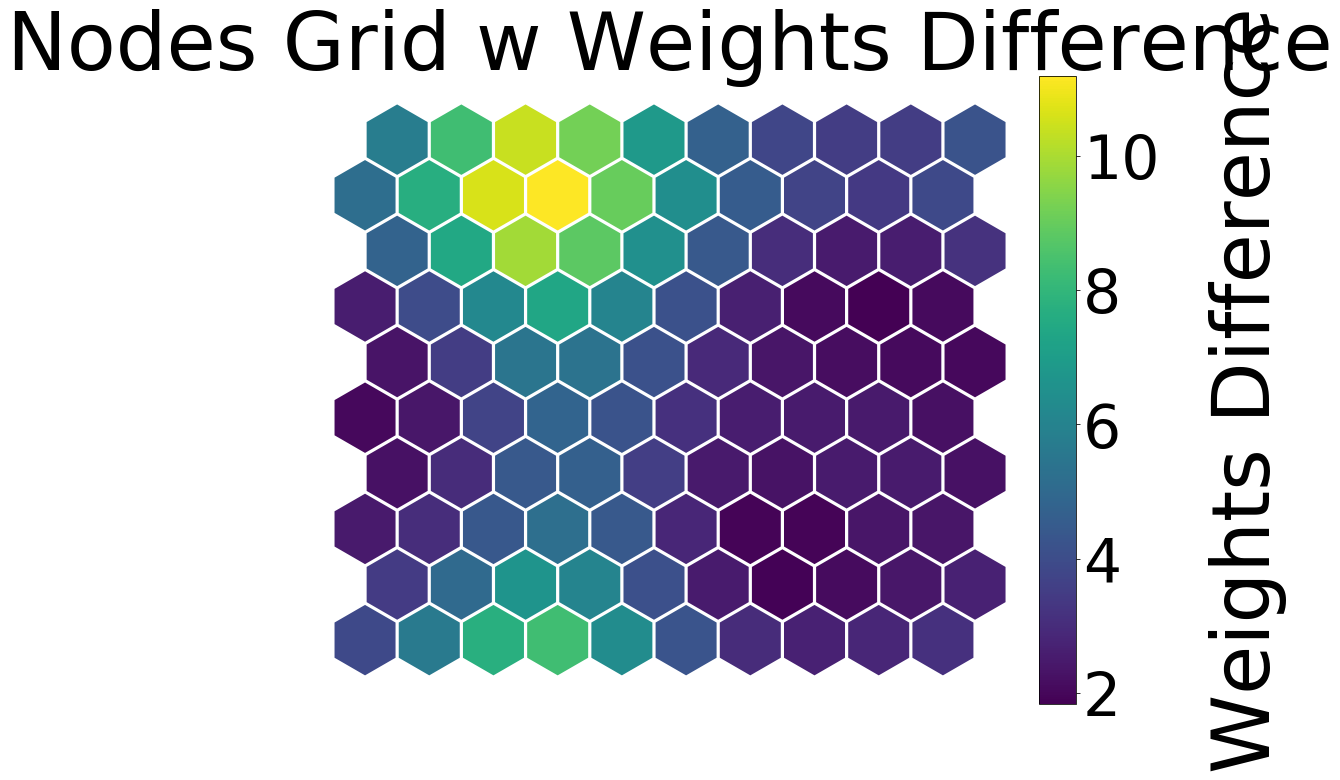

In [90]:
net.diff_graph()

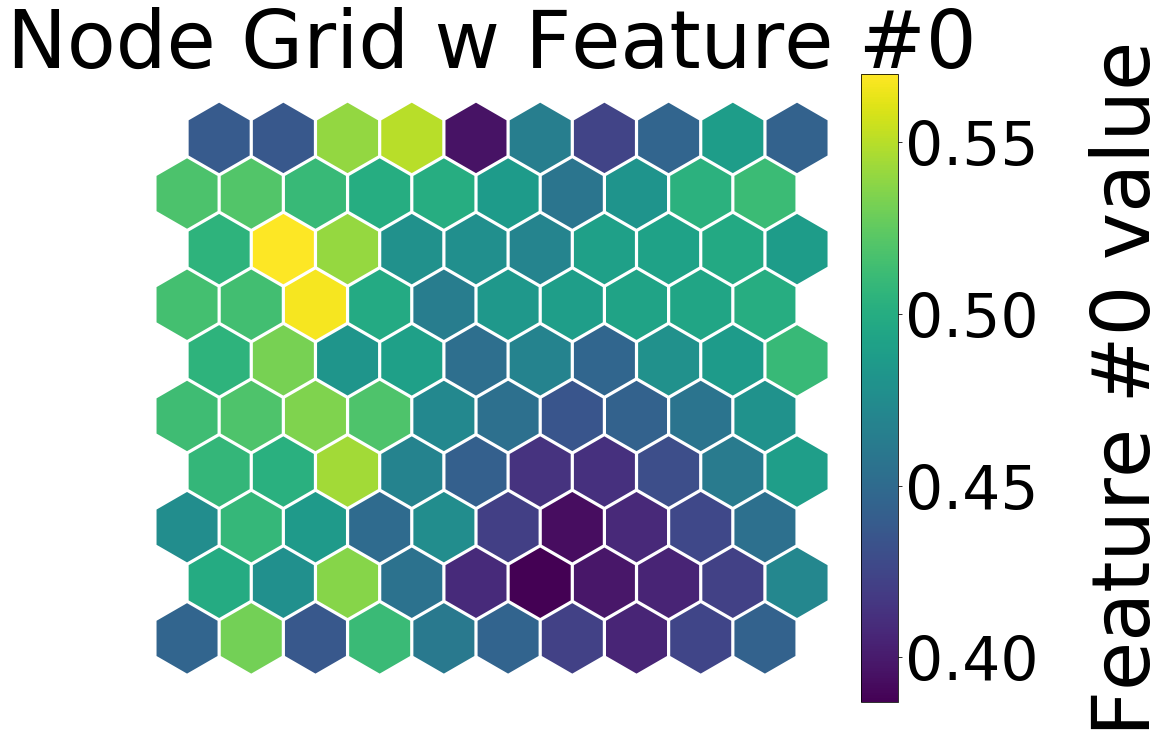

In [91]:
net.nodes_graph(colnum=0)